# Counting rice grains
An implementation demo using OpenCV by P.-A. Mudry. Made in 2021 for my programming classes.

# Some preparation and imports

In [43]:
import cv2
import matplotlib.pyplot as plot
import numpy as np

# Sets a nice dark theme for showing photographs in NB
def setGraph(sizeX = 15, sizeY = 15):    
    plot.figure(figsize=(sizeX, sizeY))
    plot.tick_params(axis='both', colors='gray')
    plot.xlim(0, width), plot.ylim(0, width)
    plot.style.use('dark_background')


# Let's get started

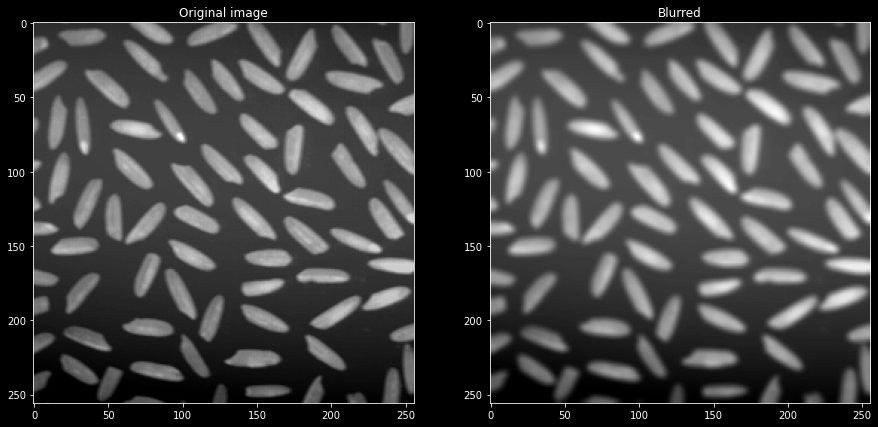

In [44]:
rice_orig = cv2.imread('images/rice2.png')
rice_orig = cv2.cvtColor(rice_orig, cv2.COLOR_BGR2GRAY)
width = len(rice_orig[0])

# Add some blur to remove noise
rice_blur = cv2.convertScaleAbs(rice_orig, alpha=1, beta = 0)
rice_blur = cv2.GaussianBlur(rice_blur, (5,5), 5)

# Display stuff
ims = [rice_orig, rice_blur]
titles = ['Original image', 'Blurred']

setGraph()

for i in range(len(ims)):    
    plot.subplot(1, len(ims), i+1)
    plot.title(titles[i])
    plot.imshow(ims[i], cmap='gray')    


Simple threshold will not work as the illumination is not even on the whole image...

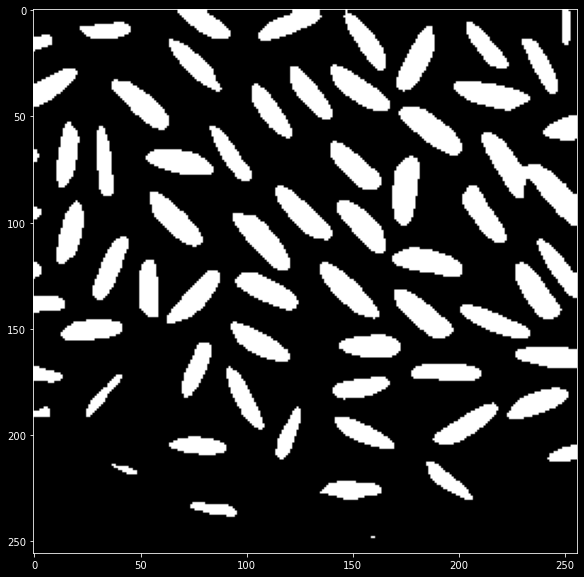

In [45]:
# Binary dumb threshold
ret,tmp = cv2.threshold(rice_blur, 140, 255, cv2.THRESH_BINARY)
plot.figure(figsize=(10, 10))
plot.imshow(tmp, cmap='gray')

Let's try something better!

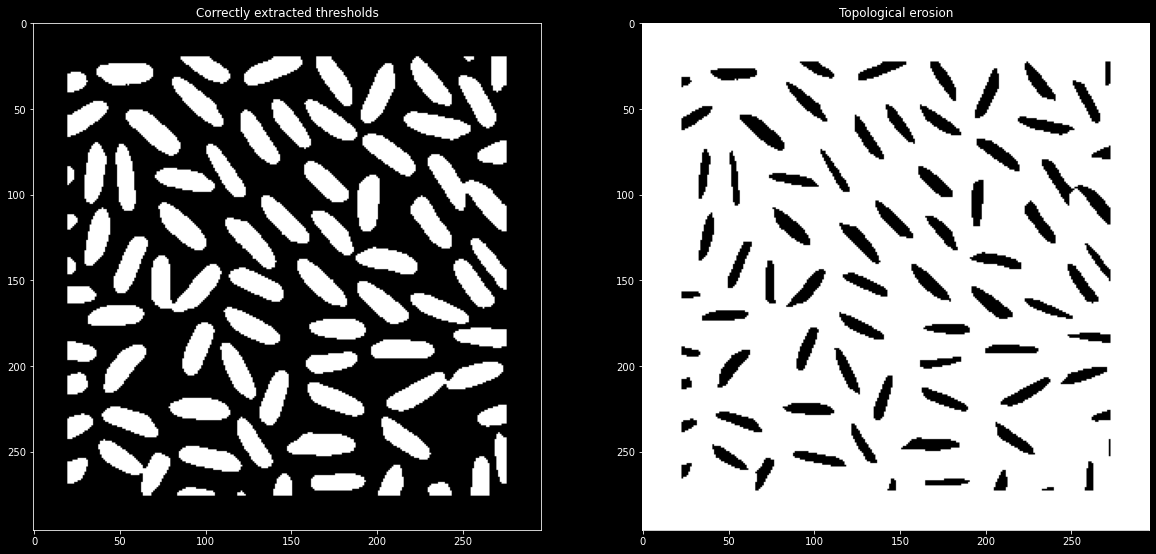

In [63]:
# Threshold the image using mean thresholding
rice_ad = cv2.adaptiveThreshold(rice_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 31, 0)

# We need to add some border around the image to segment it correctly, filled with zeroes
rice_ad = cv2.copyMakeBorder(rice_ad, top=20, bottom=20, right=20, left=20, borderType=cv2.BORDER_CONSTANT, value=[0])

# Apply some topolgy operators
kernel = np.ones((3,3), np.uint8)
rice_dilated = cv2.erode(rice_ad,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)), iterations = 3)

# Extract borders
rice = cv2.bitwise_not(rice_dilated)

setGraph(20, 12)

plot.subplot(1, 2, 1)
plot.title('Correctly extracted thresholds')
plot.imshow(rice_ad, cmap='gray')
plot.subplot(1, 2, 2)
plot.title('Topological erosion')
plot.imshow(rice, cmap='gray')

Number of contours detected = 76


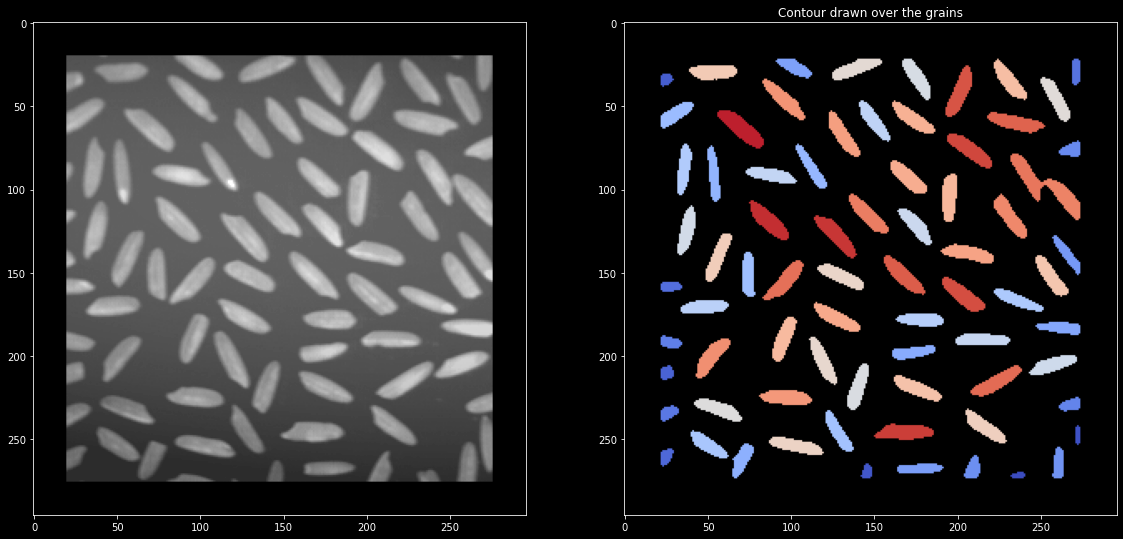

In [60]:
# Make a new plot
setGraph(30, 15)
plot.subplot(1, 3 ,1)

plot.imshow(cv2.copyMakeBorder(rice_orig, top=20, bottom=20, right=20, left=20, borderType=cv2.BORDER_CONSTANT, value=[0]), cmap='gray')

# Use OpenCV to detect the contours
contours, hierarchy = cv2.findContours(rice,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours detected = {}".format(str(len(contours))))
rice_contours = rice_dilated
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= False)

result = cv2.cvtColor(rice_contours, cv2.COLOR_GRAY2RGB)

import matplotlib as cm, random
cmap = cm.cm.get_cmap('coolwarm')

for i in range(len(sorted_contours[:-1])):
    # Choose nice colors from palette, one color per contour
    color = cmap(i / len(sorted_contours))          
    color = list(map(lambda x : x * 255, color) )
    # Contour is drawn of the whole polygon for clarity, other values (int) are possible for
    # smaller contours
    cv2.drawContours(result, sorted_contours, i, color, thickness=cv2.FILLED)

plot.subplot(1,3,2)
plot.title('Contour drawn over the grains')
plot.imshow(result)

# Now playing a bit with the detected rice grains

Number of found valid rice grains is 75


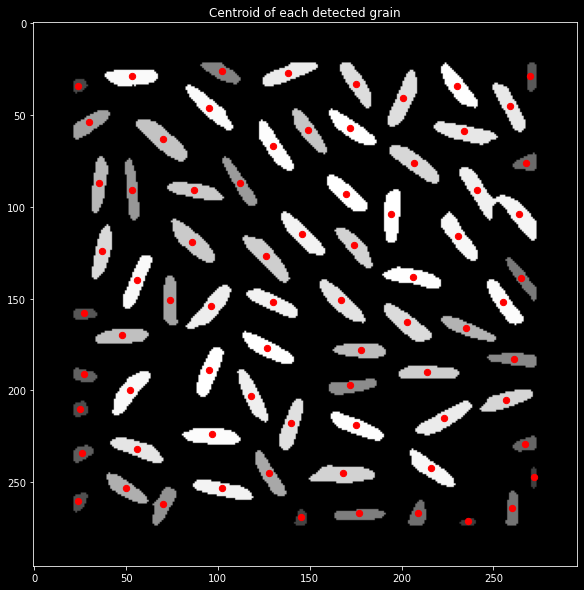

In [61]:
plot.figure(figsize=(10, 10))
plot.title('Centroid of each detected grain')
plot.imshow(result[:, :, 0], cmap='gray')

# Take only those which are big enough and not the overall contour
valids = [c for c in sorted_contours[:-1] if cv2.contourArea(c) > 1]

# Compute and display the centroid of each grain
for m in valids:
    M = cv2.moments(m)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    plot.scatter(cx, cy, c='r', s=40)

print(f'Number of found valid rice grains is {len(valids)}')

Text(0.5, 1.0, 'Histogram of grain sizes')

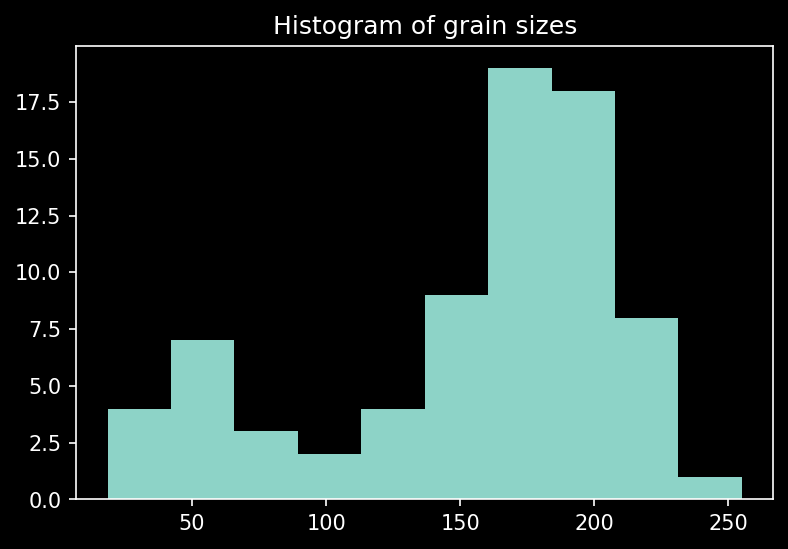

In [62]:
# Sizes of rice grains histogram
sizes = list(map(lambda x : cv2.contourArea(x), valids))

plot.figure(dpi=150)
plot.hist(sizes)
plot.title('Histogram of grain sizes')